In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import math
from datetime import date
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import svm, kernel_ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pd.set_option("display.max_rows", 100, "display.max_columns", 100)
# pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

def p(s):
    print(s)
    
pd.DataFrame.len = pd.Index.len = lambda x: print(len(x))

In [3]:
# Common function definitions
def printStats(y_dev, y_pred):
    # Graph
    plt.scatter(y_dev, y_pred)
    plt.plot(y_pred,y_pred,color='black')
    plt.show()
    
    # Stats
    mae = mean_absolute_error(y_dev, y_pred).round(1)
    rmse = round(math.sqrt(mean_squared_error(y_dev, y_pred)),1)
    r2 = r2_score(y_dev, y_pred).round(2)
    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')
    print(f'R^2: {r2}')
    
def cvGrid(params):
    names = ['param_' + x for x in list(params.keys())]
    return pd.DataFrame(grid.cv_results_)[names+['mean_test_score','std_test_score','rank_test_score','mean_fit_time','mean_score_time','std_fit_time','std_score_time']].sort_values(names)


In [4]:
# Partition training, dev, and test data
seasonHist = pd.read_csv('../seasonHist.csv')
X = seasonHist \
    .loc[:,seasonHist.columns.str.contains('-\d+') | seasonHist.columns.str.match('fanPts')] \
    .drop('fanPts',axis=1) \
    .fillna(0)
y = seasonHist.fanPts

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_dev_raw, X_test_raw, y_dev, y_test = train_test_split(X_test_raw, y_test, test_size=0.5, random_state=0)

# Scale
ss = preprocessing.StandardScaler()
X_train_std = pd.DataFrame(ss.fit_transform(X_train_raw), columns=X_train_raw.columns)
X_dev_std = pd.DataFrame(ss.fit_transform(X_dev_raw), columns=X_dev_raw.columns)
X_test_std = pd.DataFrame(ss.fit_transform(X_test_raw), columns=X_test_raw.columns)

# Manually downselect useful columns
keepCols = \
    X.columns.str.contains('fanPts') | \
    X.columns.str.contains('^complete_pass') | \
    X.columns.str.contains('rush_attempt') | \
    X.columns.str.contains('yards_gained') | \
    X.columns.str.contains('^touchdown')

X_train_select, X_dev_select, X_test_select = X_train_raw.loc[:,keepCols], X_dev_raw.loc[:,keepCols], X_test_raw.loc[:,keepCols]
X_train_std_select, X_dev_std_select, X_test_std_select = X_train_std.loc[:,keepCols], X_dev_std.loc[:,keepCols], X_test_std.loc[:,keepCols]

### Kernel Ridge Regression

#### Base models - various kernels

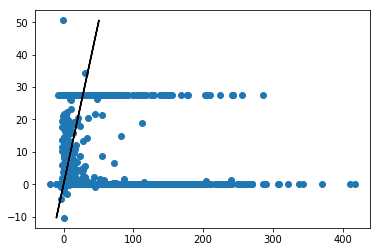

MAE: 49.8
RMSE: 78.7
R^2: -0.53


In [7]:
X_train, X_dev, y_train, y_dev = X_train_raw, X_dev_raw, y_train, y_dev

m = kernel_ridge.KernelRidge(kernel='rbf')
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

C:\Users\mrkawa\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=8.68019e-22): result may not be accurate.
  overwrite_a=False)


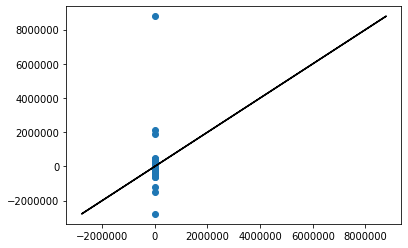

MAE: 28337.2
RMSE: 246096.3
R^2: -14911022.49


In [4]:
X_train, X_dev, y_train, y_dev = X_train_raw, X_dev_raw, y_train, y_dev

m = kernel_ridge.KernelRidge(kernel='poly')
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

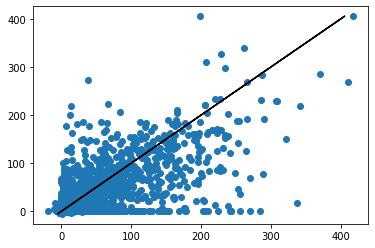

MAE: 29.9
RMSE: 50.4
R^2: 0.38


In [5]:
X_train, X_dev, y_train, y_dev = X_train_raw, X_dev_raw, y_train, y_dev

m = kernel_ridge.KernelRidge(kernel='linear')
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

#### Linear Kernel, GridSearchCV

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  21 out of  25 | elapsed:  1.4min remaining:   16.1s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  1.6min finished


{'alpha': 100, 'kernel': 'linear'}


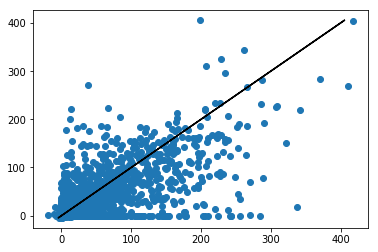

MAE: 29.9
RMSE: 50.3
R^2: 0.38


C:\Users\e358021\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\e358021\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\e358021\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_

,param_kernel,param_alpha,mean_test_score,std_test_score,rank_test_score,mean_fit_time,mean_score_time,std_fit_time,std_score_time
0,linear,0.010,0.391,0.032,5,9.511,0.255,1.980,0.076
1,linear,0.100,0.391,0.032,4,11.499,0.273,0.284,0.026
2,linear,1,0.391,0.032,3,11.027,0.272,0.425,0.048
3,linear,10,0.392,0.032,2,12.759,0.309,0.544,0.049
4,linear,100,0.392,0.033,1,10.600,0.197,2.594,0.055


In [14]:
X_train, X_dev, y_train, y_dev = X_train_raw, X_dev_raw, y_train, y_dev

params = {
    'kernel':['linear'],
    'alpha':[10**x for x in range(-2,3)]
}

grid = GridSearchCV(
    kernel_ridge.KernelRidge(),
    params,
    n_jobs = -1,
    verbose = 10,
    cv = 5
).fit(X_train,y_train)

print(grid.best_params_)

m = kernel_ridge.KernelRidge(**grid.best_params_)
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

cvGrid(params)

#### Linear Kernel,  GridSearchCV, standardized

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   39.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  13 out of  25 | elapsed:  1.2min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:  1.2min remaining:   41.7s
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:  1.6min remaining:   30.5s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:  1.7min remaining:   14.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  1.8min finished


{'alpha': 1, 'kernel': 'linear'}


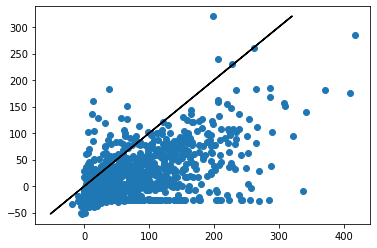

MAE: 51.7
RMSE: 67.7
R^2: -0.13


,param_kernel,param_alpha,mean_test_score,std_test_score,rank_test_score,mean_fit_time,mean_score_time,std_fit_time,std_score_time
0,linear,0.010,-0.114,0.053,3,36.613,0.196,0.715,0.030
1,linear,0.100,-0.114,0.053,2,32.494,0.197,6.760,0.034
2,linear,1,-0.114,0.053,1,30.388,0.176,1.522,0.026
3,linear,10,-0.114,0.054,4,28.276,0.176,2.830,0.051
4,linear,100,-0.116,0.053,5,27.171,0.121,3.725,0.043


In [5]:
X_train, X_dev, y_train, y_dev = X_train_std_select, X_dev_std_select, y_train, y_dev

params = {
    'kernel':['linear'],
    'alpha':[10**x for x in range(-2,3)]
}

grid = GridSearchCV(
    kernel_ridge.KernelRidge(),
    params,
    n_jobs = -1,
    verbose = 10,
    cv = 5
).fit(X_train,y_train)

print(grid.best_params_)

m = kernel_ridge.KernelRidge(**grid.best_params_)
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

cvGrid(params)

#### Linear Kernel, GridSearchCV, standardized, hand-selected features

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   59.9s
[Parallel(n_jobs=-1)]: Done  13 out of  25 | elapsed:  1.1min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:  1.2min remaining:   40.2s
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:  1.5min remaining:   28.6s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:  1.6min remaining:   13.2s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  1.7min finished


{'alpha': 1, 'kernel': 'linear'}


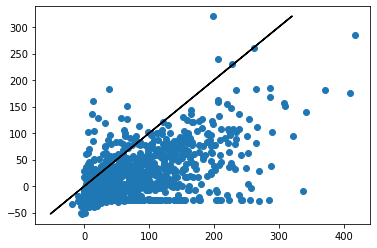

MAE: 51.7
RMSE: 67.7
R^2: -0.13


,param_kernel,param_alpha,mean_test_score,std_test_score,rank_test_score,mean_fit_time,mean_score_time,std_fit_time,std_score_time
0,linear,0.010,-0.114,0.053,3,34.257,0.198,1.329,0.042
1,linear,0.100,-0.114,0.053,2,32.833,0.167,4.031,0.048
2,linear,1,-0.114,0.053,1,31.370,0.176,2.553,0.045
3,linear,10,-0.114,0.054,4,27.126,0.177,4.452,0.031
4,linear,100,-0.116,0.053,5,25.838,0.109,4.493,0.030


In [6]:
X_train, X_dev, y_train, y_dev = X_train_std_select, X_dev_std_select, y_train, y_dev

params = {
    'kernel':['linear'],
    'alpha':[10**x for x in range(-2,3)]
}

grid = GridSearchCV(
    kernel_ridge.KernelRidge(),
    params,
    n_jobs = -1,
    verbose = 10,
    cv = 5
).fit(X_train,y_train)

print(grid.best_params_)

m = kernel_ridge.KernelRidge(**grid.best_params_)
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

cvGrid(params)